### Task 3.3: Transpile and Circuit Optimization

In [2]:
import numpy as np
import sys, platform
import numpy as np
from qiskit.circuit.library import iqp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, random_hermitian, Pauli
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

print("Python full:", sys.version)          # e.g. '3.12.5 (main, ...)'
print("Python tuple:", sys.version_info)     # e.g. sys.version_info(major=3, minor=12, micro=5, ...)
print("Python short:", platform.python_version())  # e.g. '3.12.5'
print("Executable:", sys.executable)         # path to the kernel's python


Python full: 3.12.9 | packaged by conda-forge | (main, Mar  4 2025, 22:44:42) [Clang 18.1.8 ]
Python tuple: sys.version_info(major=3, minor=12, micro=9, releaselevel='final', serial=0)
Python short: 3.12.9
Executable: /opt/homebrew/anaconda3/envs/qiskit2x/bin/python


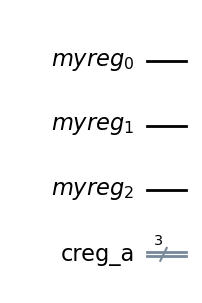

cir_isa is of type <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>))


In [6]:
## Using Estimator

from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister, Parameter, ParameterVector
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, SamplerV2

qr=QuantumRegister(3, 'myreg')
cr=ClassicalRegister(3, 'creg_a')
qc=QuantumCircuit(qr, cr)
# qc.h(2)
# qc.measure(qr,cr)
# with qc.if_test((cr[2], 1)) as else_:
#     qc.z(1)
# with else_:
#     qc.h(1)

display(qc.draw('mpl'))
sv=QiskitRuntimeService()
backend=sv.backends()[0]
pm=generate_preset_pass_manager(backend=backend, optimization_level=3)
obs=SparsePauliOp('XII')
cir_isa=pm.run(qc)
print('cir_isa is of type', type(cir_isa))
obs_isa=obs.apply_layout(cir_isa.layout)

PUB1=(cir_isa, obs_isa, [], 4)

# estimator=EstimatorV2(mode=backend,shots=4000)
estimator=EstimatorV2(mode=backend)
# job=estimator.run([(cir_isa, obs_isa)])
job=estimator.run([(cir_isa, obs_isa, None, 0.04)])
results=job.result()

print(results[0].data)

In [9]:
## Unroll3qOrMore: Recursively expands 3q+ gates until the circuit only contains 2q or 1q gates.
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroll3qOrMore

pm = PassManager([Unroll3qOrMore(target=backend.target)])  # or basis_gates=[...]
qc_unrolled = pm.run(qc)


In [16]:
from qiskit import QuantumCircuit
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroll3qOrMore

# 1) Build a circuit with a 3-qubit gate (ccx)
qc = QuantumCircuit(3, name="before")
qc.ccx(0, 1, 2)   # Toffoli: controls q0,q1; target q2

# 2) Unroll any 3+ qubit gates into 1- and 2-qubit operations
# Choose a basis that includes the standard ccx decomposition primitives
basis = ["cx", "h", "t", "tdg", "s", "sdg", "x"]
pm = PassManager([Unroll3qOrMore(basis_gates=basis)])
qc_after = pm.run(qc)

print("=== BEFORE ===")
print(qc.draw())
print("\n=== AFTER (no 3q+ gates) ===")
print(qc_after.draw())


=== BEFORE ===
          
q_0: ──■──
       │  
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘

=== AFTER (no 3q+ gates) ===
          
q_0: ──■──
       │  
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘


In Qiskit 2.2.x, Unroll3qOrMore expands every 3-qubit-or-larger instruction into 1–2-qubit gates unless that instruction’s name is listed in basis_gates or is natively supported by the provided target—in which case it’s preserved.

In [15]:
from qiskit import QuantumCircuit
from qiskit.transpiler import PassManager, generate_preset_pass_manager
from qiskit.transpiler.passes import Unroll3qOrMore

# 1) Build a circuit with a 3-qubit gate (ccx)
qc = QuantumCircuit(3, name="before")
qc.ccx(0, 1, 2)   # Toffoli: controls q0,q1; target q2

# 2) Unroll any 3+ qubit gates into 1- and 2-qubit operations
# Choose a basis that includes the standard ccx decomposition primitives
basis = ["cx", "h", "t", "tdg", "s", "sdg", "x"]
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_after = pm.run(qc)

print("=== BEFORE ===")
print(qc.draw())
print("\n=== AFTER optimization ===")
print(qc_after.draw())


=== BEFORE ===
          
q_0: ──■──
       │  
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘

=== AFTER optimization ===
global phase: 7π/8
         ┌──────────┐┌────┐┌─────────┐                                    »
q_0 -> 3 ┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├────────────────────────────────────»
         └──┬───┬───┘└────┘└─────────┘┌──────┐┌────────┐┌────┐┌──────────┐»
q_2 -> 4 ───┤ X ├─────────────────────┤0     ├┤ Rz(-π) ├┤ √X ├┤ Rz(3π/4) ├»
         ┌──┴───┴───┐┌────┐┌─────────┐│  Ecr │├────────┤├───┬┘└──────────┘»
q_1 -> 5 ┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├┤1     ├┤ Rz(-π) ├┤ X ├─────────────»
         └──────────┘└────┘└─────────┘└──────┘└────────┘└───┘             »
«               ┌──────┐ ┌────────┐                                 »
«q_0 -> 3 ──────┤1     ├─┤ Rz(-π) ├─────────────────────────────────»
«         ┌────┐│  Ecr │┌┴────────┴┐┌────┐┌──────────┐┌────┐┌──────┐»
«q_2 -> 4 ┤ √X ├┤0     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤0     ├»
«         └────┘└──────┘└──────────┘└────┘└──────

In [17]:
### PassManager vs generate_preset_pass_manager

# BasisTranslator
- ..BasisTranslator is a transpiler from "TransformationPass" class.
- converts as many gates as it can in a circuit to the target basis ("target" is an input the user provides).  Some gates cannot be converted because they may be custom 3-qubit operations, that cannot be decomposed by BasisTranslator.  That's why Unroll3qOrMore is typically used before BasisTranslator.
- It won’t magically break an arbitrary 3+-qubit instruction into 1–2-qubit ops unless a named equivalence exists, so we typically run Unroll3qOrMore immediately before to guarantee the circuit only has 1–2-qubit gates before translating to the device’s native basis.
- 


In [23]:
theta=ParameterVector('theta',3)
phi=ParameterVector('phi',2)

qc = QuantumCircuit(3,3)
qc.rx(theta[0],0)
qc.rx(theta[1],1)
qc.rx(theta[2],2)
print(qc.parameters)
qc.assign_parameters({theta:[0,0,0]}, inplace=True)
print(qc.parameters)

ParameterView([ParameterVectorElement(theta[0]), ParameterVectorElement(theta[1]), ParameterVectorElement(theta[2])])
ParameterView([])


In [25]:
from qiskit import QuantumCircuit
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator, Unroll3qOrMore


qc = QuantumCircuit(3,3)
qc.rx(0,0)

pm = PassManager([
    Unroll3qOrMore(),                           # ensure ≤2-qubit ops first
    BasisTranslator(target_basis=["cx","rz","sx","x"]),  # land in a standard basis
])
qc_in_basis = pm.run(qc)


TypeError: BasisTranslator.__init__() missing 1 required positional argument: 'equivalence_library'

In [26]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
from qiskit.circuit.equivalence_library import EquivalenceLibrary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator

# Define a custom 1-qubit gate and an equivalence for it
myg = Gate("myg", 1, [])
# Build its decomposition (here: pretend myg == rz(pi/4); replace with your real decomp)
decomp = QuantumCircuit(1, name="myg_decomp")
decomp.rz(0.25*3.141592653589793, 0)

# Register the equivalence
elib = EquivalenceLibrary()
elib.add_equivalence(myg, decomp)

# Circuit that uses your custom gate
qc = QuantumCircuit(1)
qc.append(myg, [0])

# Translate using your custom rules into a simple target basis
pm = PassManager([
    BasisTranslator(target_basis=["rz","sx","x"], equivalence_library=elib)
])
qc_translated = pm.run(qc)


In [32]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
from qiskit.circuit.equivalence_library import EquivalenceLibrary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator

# Define a custom 1-qubit gate and an equivalence for it
myg = Gate("myg", 1, [])
# Build its decomposition (here: pretend myg == rz(pi/4); replace with your real decomp)
decomp = QuantumCircuit(1, name="myg_decomp")
decomp.rz(0.25*3.141592653589793, 0)

# Register the equivalence
elib = EquivalenceLibrary()
elib.add_equivalence(myg, decomp)

# Circuit that uses your custom gate
qc = QuantumCircuit(1)
qc.append(myg, [0])

# Translate using your custom rules into a simple target basis
pm = PassManager([
    BasisTranslator(equivalence_library=elib, target_basis=['cx'])
])
qc_translated = pm.run(qc)


TranspilerError: 'Unable to translate the operations in the circuit: {("myg", 1)} to the backend\'s (or manually specified) target basis: {"cx", "measure", "reset", "barrier", "snapshot", "delay", "store"}. This likely means the target basis is not universal or there are additional equivalence rules needed in the EquivalenceLibrary being used. For more details on this error see: https://quantum.cloud.ibm.com/docs/api/qiskit/qiskit.transpiler.passes.BasisTranslator#translation-errors'

### new

In [26]:
import numpy as np
import sys, platform
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import iqp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, random_hermitian, Pauli
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, SamplerV2

print("Python full:", sys.version)          # e.g. '3.12.5 (main, ...)'
print("Python tuple:", sys.version_info)     # e.g. sys.version_info(major=3, minor=12, micro=5, ...)
print("Python short:", platform.python_version())  # e.g. '3.12.5'
print("Executable:", sys.executable)         # path to the kernel's python


Python full: 3.12.9 | packaged by conda-forge | (main, Mar  4 2025, 22:44:42) [Clang 18.1.8 ]
Python tuple: sys.version_info(major=3, minor=12, micro=9, releaselevel='final', serial=0)
Python short: 3.12.9
Executable: /opt/homebrew/anaconda3/envs/qiskit2x/bin/python


In [27]:
sv = QiskitRuntimeService()
backend = sv.backends()[1]

estimator=EstimatorV2(mode=backend)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

cir = QuantumCircuit(2,2)
cir.h(0)

cir_isa=pm.run(cir)
obs = SparsePauliOp('XX')
obs_isa=obs.apply_layout(cir_isa.layout)

PUB=(cir_isa, obs_isa, None, 0.003)

# insert additional settings
estimator.options.twirling.enable_gates=True
estimator.options.twirling.enable_measure=True

job=estimator.run([PUB], precision=0.5)
results=job.result()

In [28]:
results

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>)), metadata={'shots': 111136, 'target_precision': 0.003, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': True, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

In [29]:
results[0]

PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>)), metadata={'shots': 111136, 'target_precision': 0.003, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})

In [30]:
results[0].data

DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>))

In [31]:
results[0].data.evs

array(1.49067419)

In [24]:
import numpy as np

results = job.result()
r0 = results[0]  # PubResult

# Safe for both scalar (0-D) and vector cases
ev  = float(np.asarray(r0.data.evs).reshape(-1)[0])
std = float(np.asarray(r0.data.stds).reshape(-1)[0])

print("⟨XX⟩ =", ev, "±", std)


⟨XX⟩ = 1.514092967378246 ± 0.009509092517493786


In [25]:
r0.data.evs

array(1.51409297)

### Practice Parameter

In [37]:
from qiskit.circuit import ParameterVector

sv = QiskitRuntimeService()
backend = sv.backends()[1]

estimator=EstimatorV2(mode=backend)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

### Insert ParameterVector
theta=ParameterVector('theta',3)
phi=ParameterVector('phi',2)

cir = QuantumCircuit(2,2)
cir.h(0)
cir.rx(theta[0], 0)
cir.ry(theta[1], 1)
cir.ry(theta[2],1)
print('cir.parameters should have theta[0] and theta[1]')
print(cir.parameters)
cir.assign_parameters({theta:[0.1,0.1,0.1]}, inplace=True)
print('cir.parameters should be empty')
print(cir.parameters)

cir_isa=pm.run(cir)
obs = SparsePauliOp('XX')
obs_isa=obs.apply_layout(cir_isa.layout)

PUB=(cir_isa, obs_isa, None, 0.003)

job=estimator.run([PUB], precision=0.5)
results=job.result()

cir.parameters should have theta[0] and theta[1]
ParameterView([ParameterVectorElement(theta[0]), ParameterVectorElement(theta[1]), ParameterVectorElement(theta[2])])
cir.parameters should be empty
ParameterView([])


In [43]:
results[0].data.evs

array(0.18781664)

In [44]:
results[0].data.stds

array(0.00569085)

### Registers and Control Flow

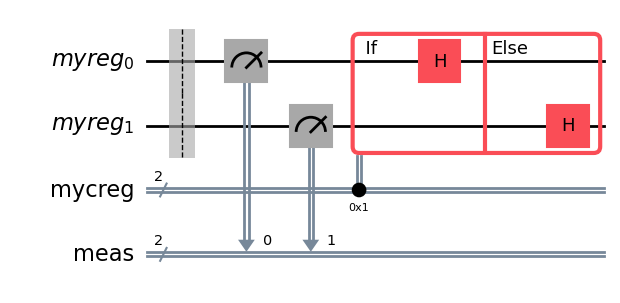

In [52]:
from qiskit.circuit import QuantumRegister, ClassicalRegister, Parameter, ParameterVector

qr=QuantumRegister(2,'myreg')
cr=ClassicalRegister(2,'mycreg')

qc=QuantumCircuit(qr,cr)
qc.measure_all()

with qc.if_test((qc.cregs[0], 0b01)) as else_:
    qc.h(0)
with else_:
    qc.h(1)

qc.draw('mpl')


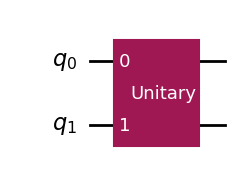

In [54]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, Operator

qc = QuantumCircuit(2)
gate_XI = Operator(Pauli('XI'))    # 2-qubit unitary for X⊗I
qc.append(gate_XI, [0, 1])
qc.draw('mpl')